| Description

Authors of notebook: Mateus Balda and Alessandro Bof

Reference paper and dataset: https://www.frontiersin.org/journals/psychiatry/articles/10.3389/fpsyt.2021.707581/full

| Notebook structure
0. Setup and Imports
1. Utility Functions  
2. Data Loading and Preprocessing
3. Data Preparation for Training
4. Model Definition
5. Training and Evaluation
6. Results
7. Conclusions, Problems, and Limitations

| Training
1. Multiclass classification for `y` specific.disorder
2. Synthetic data (CTGAN)
3. Training all features

## | 0. Setup and Imports

In [1]:
!pip install -q torchsummary;
!pip install -q torchviz;
!pip install -q imbalanced-learn==0.12.4;

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

from warnings import filterwarnings
filterwarnings('ignore')

torch.__version__

'1.13.1+cu117'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
np.random.seed(123)
torch.manual_seed(123)

## | 1. Utility Functions

### 1. OUTLIERS

In [5]:
def detect_outliers_summary(df):
    outliers_summary = {}

    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)][col]
        
        outliers_summary[col] = {
            'num_outliers': len(outliers),
            'percent_outliers': len(outliers) / len(df) * 100,
            'outliers': outliers.tolist(),
            'lower_limit': lower_limit,
            'upper_limit': upper_limit
        }

    return pd.DataFrame(outliers_summary).T


def treat_all_outliers_iqr(df, factor=1.5):
    df_treated = df.copy()
    
    for column in df_treated.select_dtypes(include=[np.number]).columns:
        Q1 = np.percentile(df_treated[column], 25)
        Q3 = np.percentile(df_treated[column], 75)
        IQR = Q3 - Q1

        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        df_treated[column] = np.clip(df_treated[column], lower_bound, upper_bound)

    return df_treated

### 2. NANS

In [6]:
def remove_missing_columns(df, threshold=0.5):
    limit = int(threshold * len(df))
    df = df.dropna(thresh=limit, axis=1)
    return df
    
def find_most_null_column(df, threshold=0.5):
    null_ratios = df.isnull().mean()
    for col, ration in null_ratios.items():
        if ration > threshold:
            return col
    return None

def analyze_missing_values(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    total_number_nans = df.isnull().sum().sum()
    
    return missing_values, total_number_nans

def handle_nans(df):
    columns_with_nans = df.columns[df.isnull().any()].tolist()
    
    knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
    
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df[columns_with_nans]),
                                columns=columns_with_nans)
    
    df[columns_with_nans] = df_imputed[columns_with_nans]
    
    return df

## | 2. Data Loading and Preprocessing

In [7]:
df = pd.read_csv('../input/eeg-psychiatric-disorders-dataset/EEG.machinelearing_data_BRMH.csv')
df_synthetic = pd.read_csv('../input/synthetic-samples-specific-disorder-ctgan/synthetic_samples_specific_disorder_ctgan.csv', index_col=0)

df.shape, df_synthetic.shape

((945, 1149), (1443, 1144))

In [ ]:
df_synthetic.head()

,age,education,IQ,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,...,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2,specific.disorder
0,12.486723,12.720248,111.652880,2.725357,21.452343,27.299812,19.019614,25.373663,22.539893,14.994883,...,26.880195,57.820169,72.340303,113.228991,56.707236,54.023712,5.539792,38.782711,-5.282597,Schizophrenia
1,18.546245,14.794858,91.973729,4.684256,35.090543,25.702844,21.747822,20.096341,6.902994,9.496179,...,45.567550,25.359201,81.145683,97.401796,1.298894,83.881808,24.405675,13.098263,40.959226,Schizophrenia
2,13.599379,11.907947,107.347258,9.349618,19.421081,31.597079,24.319588,11.128257,1.524109,10.764051,...,11.019094,31.597541,48.291539,111.414746,56.116052,39.928965,19.604073,24.049729,79.182487,Schizophrenia
3,27.346908,12.815714,82.375051,34.597320,50.193828,8.127347,23.540958,30.025157,17.017312,0.138230,...,33.195094,1.373304,56.348701,98.378207,-3.453199,69.421351,-9.791777,9.909273,83.766819,Schizophrenia
4,15.558836,19.125513,108.652151,-1.817344,29.857772,20.471747,24.993812,15.728950,18.494554,2.248556,...,40.036583,31.316394,65.225965,62.629056,14.402702,5.156964,1.741342,41.310525,53.742409,Schizophrenia


In [9]:
# Checking / imputing Nan

output1 = analyze_missing_values(df)
output2 = find_most_null_column(df)
df = remove_missing_columns(df)
output3 = analyze_missing_values(df)
df = handle_nans(df)

display(output1)
display(HTML('<hr>'))
display(output2)
display(HTML('<hr>'))
display(output3)
display(df.shape)
display(HTML('<hr>'))
display(df.isna().sum().sum())
display(df)

(education        15
 IQ               13
 Unnamed: 122    945
 dtype: int64,
 973)

'Unnamed: 122'

(education    15
 IQ           13
 dtype: int64,
 28)

(945, 1148)

0

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,13.43871,101.580472,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.00000,120.000000,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.00000,113.000000,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.00000,126.000000,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.00000,112.000000,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,941,M,22.0,2014.8.28,13.00000,116.000000,Healthy control,Healthy control,41.851823,36.771496,...,82.905657,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230
941,942,M,26.0,2014.9.19,13.00000,118.000000,Healthy control,Healthy control,18.986856,19.401387,...,65.917918,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868
942,943,M,26.0,2014.9.27,16.00000,113.000000,Healthy control,Healthy control,28.781317,32.369230,...,61.040959,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111
943,944,M,24.0,2014.9.20,13.00000,107.000000,Healthy control,Healthy control,19.929100,25.196375,...,99.113664,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446


In [10]:
# detecting outliers

outliers_summary = detect_outliers_summary(df)
outliers_summary.to_csv('outliers_summary.csv', index=True)
outliers_summary['num_outliers'].sum()

26452

In [11]:
X = df.iloc[:,8:]
target_name = 'specific.disorder'
target = df[target_name]
quantitative_features = df.loc[:, ['age', 'education', 'IQ']]

assert X.shape[0] == target.shape[0] == quantitative_features.shape[0], "Inconsistent number of samples across datasets"

X.shape, target.shape, quantitative_features.shape

((945, 1140), (945,), (945, 3))

In [12]:
df_real = pd.concat([quantitative_features, X, target], axis=1)

df_combined = pd.concat([df_real, df_synthetic], axis=0).reset_index(drop=True)

X = df_combined.iloc[:, 3:-1]
quantitative_features = df_combined.loc[:, ['age', 'education', 'IQ']]
target = df_combined[target_name]
X_concatenated = pd.concat([quantitative_features, X], axis=1)

assert target.index.equals(X.index) and target.index.equals(X_concatenated.index), "Indices of target and features do not match"

X.shape, target.shape, quantitative_features.shape, X_concatenated.shape

((2388, 1140), (2388,), (2388, 3), (2388, 1143))

In [13]:
CLASS_NAMES = np.unique(target).tolist()
CLASS_NAMES

['Acute stress disorder',
 'Adjustment disorder',
 'Alcohol use disorder',
 'Behavioral addiction disorder',
 'Bipolar disorder',
 'Depressive disorder',
 'Healthy control',
 'Obsessive compulsitve disorder',
 'Panic disorder',
 'Posttraumatic stress disorder',
 'Schizophrenia',
 'Social anxiety disorder']

In [14]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(target)
y_encoded = pd.Series(y_encoded, name=target_name)
(pd.DataFrame(y_encoded)).value_counts()

specific.disorder
0                    199
1                    199
2                    199
3                    199
4                    199
5                    199
6                    199
7                    199
8                    199
9                    199
10                   199
11                   199
Name: count, dtype: int64

In [ ]:
df_union = pd.concat([X_concatenated, pd.DataFrame(y_encoded)], axis=1)

assert df_union.shape[0] == X_concatenated.shape[0] == y_encoded.shape[0], "Inconsistent number of samples in the union DataFrame"
assert X_concatenated.index.equals(y_encoded.index), "Indices of features and target do not match in the union DataFrame"

display(df_union.shape)
display(df_union)
display(df_union.isna().sum().sum())

(2388, 1144)

,age,education,IQ,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,...,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2,specific.disorder
0,57.000000,13.438710,101.580472,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,16.563408,...,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029,2
1,37.000000,6.000000,120.000000,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,8.436832,...,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261,2
2,32.000000,16.000000,113.000000,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,16.523963,...,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799,2
3,35.000000,18.000000,126.000000,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,14.613650,...,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873,2
4,36.000000,16.000000,112.000000,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,15.969042,...,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2383,41.024158,21.338190,137.508387,3.897484,6.600202,11.625845,13.960831,37.676382,30.945274,11.202927,...,47.175044,25.935223,80.153058,110.550349,58.663091,41.690877,-5.156744,81.195055,2.983596,1
2384,55.499292,12.990695,80.726012,1.785503,8.328488,30.755002,21.065130,37.601797,26.809310,29.847553,...,58.018386,62.111926,86.762645,62.187134,16.427574,66.377102,18.068607,46.783253,44.923293,1
2385,56.778344,18.878593,138.331332,19.287896,0.594376,41.444599,41.514412,41.861253,21.975527,26.688986,...,87.730085,66.344053,85.630108,85.603845,1.485398,49.566798,24.463577,111.231455,93.531027,1
2386,46.136011,15.122581,121.912296,2.706127,25.875806,38.546985,24.760639,8.782951,20.560540,15.400793,...,72.473839,80.167055,86.254430,59.050772,45.043488,80.776484,-13.517152,99.023455,3.971395,1


0

In [16]:
# pca

class PCAVarianceAnalyzer:
    def __init__(self, variance_thresholds=(0.95, 0.99)):
        self.variance_thresholds = variance_thresholds
        self.scaler = StandardScaler()
        self.pca = None
        self.explained_variance_ = None
        self.cumulative_variance_ = None
        self.n_components_ = {}
    
    def fit(self, X):

        X_scaled = self.scaler.fit_transform(X)
        
        self.pca = PCA()
        self.pca.fit(X_scaled)
        
        self.explained_variance_ = self.pca.explained_variance_ratio_
        self.cumulative_variance_ = self.explained_variance_.cumsum()
        
        for threshold in self.variance_thresholds:
            n_components = (self.cumulative_variance_ >= threshold).argmax() + 1
            self.n_components_[threshold] = n_components
            print(f"Components required for {int(threshold*100)}% of variance: {n_components}")

        self._plot_cumulative_variance()

        return X_scaled

    def transform(self, X, threshold=0.99):
        if threshold not in self.n_components_:
            raise ValueError(f"Threshold {threshold} not fitted. Call fit() first.")
        
        X_scaled = self.scaler.transform(X)
        
        pca = PCA(n_components=self.n_components_[threshold])
        X_pca = pca.fit_transform(X_scaled)

        print(f"Shape of the data after PCA with {self.n_components_[threshold]} components: {X_pca.shape}, type: {type(X_pca)}")
        
        return X_pca
    
    def _plot_cumulative_variance(self):
        plt.figure(figsize=(8, 6))
        plt.plot(self.cumulative_variance_, marker='o', linestyle='--')
        plt.title('Cumulative Explained Variance - PCA')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.grid(True)
        plt.show()


Components required for 95% of variance: 669
Components required for 99% of variance: 923


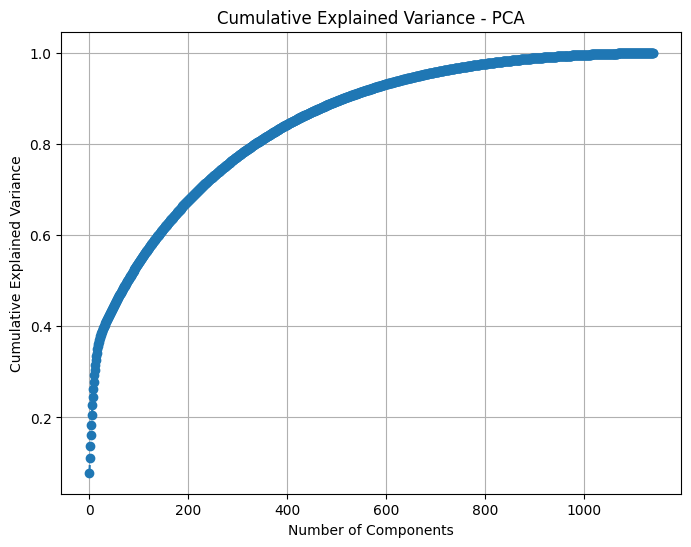

Shape of the data after PCA with 923 components: (2388, 923), type: <class 'numpy.ndarray'>


(2388, 923)

,0,1,2,3,4,5,6,7,8,9,...,913,914,915,916,917,918,919,920,921,922
0,-23.861390,2.874146,0.271160,1.356424,0.407197,-1.349226,0.342272,-0.569864,-0.519020,0.343508,...,0.084032,0.110160,0.028687,0.166609,0.140333,0.073651,0.238705,0.087644,0.241796,-0.088635
1,-13.456489,3.108488,0.815902,3.474439,-2.766690,-4.303444,0.255159,1.758428,-2.133391,-1.288306,...,-0.304291,-0.098967,-0.004858,0.040581,0.147430,-0.119016,-0.239427,-0.031554,-0.118880,-0.047284
2,-7.656287,-4.060808,-2.006914,-4.179366,6.353360,2.511693,0.611300,-3.284613,-2.758638,-0.840603,...,-0.347762,0.297920,-0.037174,-0.107050,0.221036,-0.144179,-0.008010,-0.030733,0.305578,0.104813
3,-8.808224,0.301433,-0.057428,-0.943081,1.775757,-3.013363,-1.414720,-1.726411,-0.819589,2.707014,...,0.038165,0.275033,0.275609,-0.182549,0.026456,-0.530941,0.147545,0.072548,0.141194,-0.079074
4,10.157497,-5.770620,-3.809962,-3.899335,6.295187,2.645677,0.675567,-2.861543,-1.136105,2.072782,...,0.180751,0.209799,-0.038895,0.034493,0.190758,0.007242,-0.012712,-0.127618,-0.150866,-0.133157


In [17]:
quantitative_features = df_union[['age', 'education', 'IQ']]
target = df_union[target_name]

ab_psd = df_union.filter(regex='^AB')
coh_fc = df_union.filter(regex='^COH')

df_psd_fc = pd.concat([ab_psd, coh_fc], axis=1)

pca_analyzer = PCAVarianceAnalyzer(variance_thresholds=(0.95, 0.99))
X_pca = pca_analyzer.fit(df_psd_fc)
X_pca = pca_analyzer.transform(df_psd_fc, threshold=0.99)
display(X_pca.shape)
display(pd.DataFrame(X_pca).head())


## | 3. Data Preparation for Training

In [ ]:
# X_concatenated
# y_encoded

In [ ]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        if hasattr(X, 'to_numpy'):
            X = X.to_numpy()
        if hasattr(y, 'values'):
            y = y.values
            
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15

NEURONS = [
    [2048, 1024, 512, 256, 128],
    [1536, 768, 384, 192, 96],
    [1026, 513, 256, 128, 64],
    [512, 256, 128, 64, 32],
    [256, 128, 64, 32, 16]
]

DROPOUTS = [0.10, 0.20, 0.30]
LEARNING_RATES = [0.00001, 0.0001, 0.0003]
BATCH_SIZES = [16, 24, 32]
WEIGHT_DECAYS = [0.00001, 0.0001, 0.0003]
CRITERION = nn.CrossEntropyLoss()
SCALER = StandardScaler()

NUM_EPOCHS = 500

In [ ]:
# Method to prepare datasets

def prepare_datasets(
    X, y, 
    train_ratio = TRAIN_RATIO,
    val_ratio = VAL_RATIO,
    batch_size = BATCH_SIZES[0] 
):
    assert len(X) == len(y), "X and y must be the same size"
    
    X_scaled = SCALER.fit_transform(X)
        
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_scaled, y, 
        train_size=train_ratio,
        stratify=y,
        random_state=42
    )
    
    val_size = val_ratio / (1 - train_ratio)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, 
        train_size=val_size, 
        stratify=y_temp, 
        random_state=42
    )
    
    train_dataset = EEGDataset(X_train, y_train)
    val_dataset = EEGDataset(X_val, y_val)
    test_dataset = EEGDataset(X_test, y_test)
    
    print(f"Train dataset size: {len(train_dataset)}, shape: {X_train.shape}")
    print(f"Validation dataset size: {len(val_dataset)}, shape: {X_val.shape}")
    print(f"Test dataset size: {len(test_dataset)}, shape: {X_test.shape}")
    
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    
    return {
        'loaders': {
            'train': train_loader,
            'val': val_loader,
            'test': test_loader,
        }
    }

## | 4. Model Definition 
Neural network architecture

In [22]:
class EEGANNClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, neurons, dropout=0.10):
        super(EEGANNClassifier, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, neurons[0])
        self.layer2 = nn.Linear(neurons[0], neurons[1])
        self.layer3 = nn.Linear(neurons[1], neurons[2])
        self.layer4 = nn.Linear(neurons[2], neurons[3])
        self.layer5 = nn.Linear(neurons[3], neurons[4])
        self.output_layer = nn.Linear(neurons[4], output_dim)

        self.bn1 = nn.BatchNorm1d(neurons[0])
        self.bn2 = nn.BatchNorm1d(neurons[1])
        self.bn3 = nn.BatchNorm1d(neurons[2])
        self.bn4 = nn.BatchNorm1d(neurons[3])
        self.bn5 = nn.BatchNorm1d(neurons[4])

        self.gelu = nn.GELU()

        self.dropout = nn.Dropout(p=dropout)
        
        init.xavier_uniform_(self.layer1.weight)
        init.xavier_uniform_(self.layer2.weight)
        init.xavier_uniform_(self.layer3.weight)
        init.xavier_uniform_(self.layer4.weight)
        init.xavier_uniform_(self.layer5.weight)
        init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        x = self.gelu(self.bn1(self.layer1(x))) 
        x = self.dropout(x)
        
        x = self.gelu(self.bn2(self.layer2(x)))
        x = self.dropout(x)
        
        x = self.gelu(self.bn3(self.layer3(x)))
        x = self.dropout(x)
        
        x = self.gelu(self.bn4(self.layer4(x)))
        x = self.dropout(x)
        
        x = self.gelu(self.bn5(self.layer5(x)))
        
        x = self.output_layer(x)
        
        return x

## | 5. Training and Evaluation  

In [23]:
# Method for train

def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer, 
    scheduler, 
    num_epochs,
    patience = 15,
    min_delta = 0.01
):
    
    best_loss = float('inf')
    early_stop_counter = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    final_epoch = 0

    for epoch in range(num_epochs):
        # ------------------- Train -------------------
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()
            
            optimizer.zero_grad()  # zero gradients

            # Forward pass
            outputs = model(inputs)

            # Calculate a loss
            loss = criterion(outputs, labels)
            loss.backward()  # Calculate gradients
            optimizer.step()  # Update weights

            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct_preds / total_samples
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # ------------------- Val -------------------
        model.eval()
        val_loss = 0.0
        correct_val_preds = 0
        total_val_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val_preds += (predicted == labels).sum().item()
                total_val_samples += labels.size(0)

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = correct_val_preds / total_val_samples
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        # ------------------- Logging -------------------
        print(
            f"Epoch [{epoch + 1}/{num_epochs}]"
            f" | Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}"
            f" | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}"
        )

        # ------------------- Early Stopping -------------------
        if epoch_val_loss < best_loss - min_delta:
            best_loss = epoch_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}.")
            final_epoch = epoch + 1
            break 

        # update scheduler
        scheduler.step(epoch_val_loss)

    return train_losses, val_losses, train_accs, val_accs, final_epoch

In [ ]:
def train_model_with_cv_folds(
    model,
    train_loader,
    criterion,
    optimizer, 
    scheduler, 
    num_epochs,
    patience=20, 
    min_delta=0.01  
):
    best_train_loss = float('inf')
    early_stop_counter = 0
    train_losses, train_accs = [], []
    final_epoch = 0
    
    for epoch in range(num_epochs):
        # ------------------- Train -------------------
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()
            
            optimizer.zero_grad()  # Zero gradients

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            loss.backward()  # Calculate gradients
            optimizer.step()  # Update weights

            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate epoch training loss and accuracy
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct_preds / total_samples
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # ------------------- Logging -------------------
        print(
            f"Epoch [{epoch + 1}/{num_epochs}]"
            f" | Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}"
        )

        # ------------------- Early Stopping -------------------
        if epoch_train_loss < best_train_loss - min_delta:
            best_train_loss = epoch_train_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement in train loss.")
            final_epoch = epoch + 1
            break 

        # Update the scheduler
        scheduler.step(epoch_train_loss)

    return

In [ ]:
# Methods for evaluation

def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    if not (train_losses and val_losses and train_accs and val_accs):
        return None

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(train_losses, label='Training Loss')
    axs[0].plot(val_losses, label='Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_title('Loss')

    axs[1].plot(train_accs, label='Training Accuracy')
    axs[1].plot(val_accs, label='Validation Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].set_title('Accuracy')

    fig.suptitle('Training & Validation Metrics')
    fig.tight_layout()
    return fig

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    fig.tight_layout()
    return fig

def plot_roc_curves(y_true, y_probs, class_names):
    fig, ax = plt.subplots(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
        auc = roc_auc_score(y_true == i, y_probs[:, i])
        ax.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.4f})')
    ax.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves by Class')
    ax.legend(loc='lower right')
    fig.tight_layout()
    return fig

def compute_auc_scores(y_true, y_probs, num_classes, verbose=True):
    if num_classes is None:
        return None, None

    aucs = [roc_auc_score(y_true == i, y_probs[:, i]) for i in range(num_classes)]
    mean_auc = np.mean(aucs)

    if verbose:
        # print(f"\n📈 AUC per class: {aucs}")
        print(f"📊 Mean AUC: {mean_auc:.4f}")

    return aucs, mean_auc

def print_accuracy_report(accuracy, y_true, y_pred, class_names, verbose=True):
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    
    sensitivities = {}
    specificities = {}

    for i, class_name in enumerate(class_names):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FP + FN)

        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0.0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0.0

        sensitivities[class_name] = sensitivity
        specificities[class_name] = specificity

    if verbose:
        print(f"\n-- Test Accuracy: {accuracy:.2f}%")
        print("\n-- Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names, digits=4))

        print("-- Sensitivity (Recall) por classe:")
        for cls, sens in sensitivities.items():
            print(f"  - {cls}: {sens:.4f}")

        print("\n-- Specificity por classe:")
        for cls, spec in specificities.items():
            print(f"  - {cls}: {spec:.4f}")

    return report, sensitivities, specificities


In [ ]:
import matplotlib
matplotlib.use('Agg')

def evaluate_model(
    model,
    test_loader,
    class_names,
    train_losses=None,
    val_losses=None,
    train_accs=None,
    val_accs=None,
    num_classes=None
):
    model.eval()

    fig_curves = plot_training_curves(train_losses, val_losses, train_accs, val_accs)

    all_probs, all_labels = [], []
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    pred_classes = np.argmax(all_probs, axis=1)
    accuracy = 100 * correct / total

    report, sensitivities, specificities = print_accuracy_report(
        accuracy, all_labels, pred_classes, class_names
    )

    fig_conf = plot_confusion_matrix(all_labels, pred_classes, class_names)
    fig_roc = plot_roc_curves(all_labels, all_probs, class_names)
    aucs, mean_auc = compute_auc_scores(all_labels, all_probs, num_classes)

    return {
        "accuracy": accuracy,
        "classification_report": report,
        "sensitivities": sensitivities,
        "specificities": specificities,
        "aucs": aucs,
        "mean_auc": mean_auc,
        "fig_curves": fig_curves,
        "fig_conf_matrix": fig_conf,
        "fig_roc": fig_roc
    }

In [ ]:
# Method for random search

import random

def random_search(
    num_trials=10,
    neurons=None,
    dropout_rates=None,
    learning_rates=None,
    batch_sizes=None,
    weight_decays=None,
    train_ratio=None,
    val_ratio=None,
    X=None,
    y_encoded=None,
    input_dim=None,
    output_dim=None,
    num_epochs=None,
    criterion=None,
):
    
    best_accuracy = 0
    best_params = {}
    best_results = {}
    training_values = {}
    
    for _ in range(num_trials):
        # Randomly select parameters
        neurons_choice = random.choice(neurons)
        dropout_choice = random.choice(dropout_rates)
        learning_rate_choice = random.choice(learning_rates)
        batch_size_choice = random.choice(batch_sizes)
        weight_decay_choice = random.choice(weight_decays)

        # Prepare datasets
        datasets = prepare_datasets(
            X=X, y=y_encoded,
            train_ratio=train_ratio,
            val_ratio=val_ratio,
            batch_size=batch_size_choice
        )

        # Create model
        model = EEGANNClassifier(
            input_dim=input_dim, 
            output_dim=output_dim, 
            neurons=neurons_choice, 
            dropout=dropout_choice
        ).to(device)

        optimizer = optim.Adam(
            model.parameters(), 
            lr=learning_rate_choice,
            weight_decay=weight_decay_choice
        )
        
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor = 0.1,
            patience = 3,
            min_lr = 1e-6, 
            verbose = True
        )

        # Train model
        train_losses, val_losses, train_accs, val_accs, final_epoch = train_model(
            model=model,
            train_loader=datasets['loaders']['train'],
            val_loader=datasets['loaders']['val'],
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=num_epochs
        )
        
        print(f'{neurons_choice} neurons, {dropout_choice} dropout, {learning_rate_choice} learning rate, {batch_size_choice} batch size, {weight_decay_choice} weight decay')

        # Evaluate model on test set
        test_results = evaluate_model(
            model=model, 
            test_loader=datasets['loaders']['test'],
            class_names=CLASS_NAMES,
            train_losses=train_losses,
            val_losses=val_losses,
            train_accs=train_accs,
            val_accs=val_accs,
            num_classes=output_dim,
        )
        
        
        if test_results['accuracy'] > best_accuracy:
            best_accuracy = test_results['accuracy']
            
            best_params = {
                'neurons': neurons_choice,
                'dropout': dropout_choice,
                'learning_rate': learning_rate_choice,
                'batch_size': batch_size_choice,
                'weight_decay': weight_decay_choice
            }
            
            best_results = {
                'final_epoch': final_epoch,
                'best_accuracy': test_results['accuracy'],
                'mean_auc': test_results['mean_auc'],
                'classification_report': test_results['classification_report'],
                'aucs': test_results['aucs'],
                'fig_curves': test_results['fig_curves'],
                'fig_conf_matrix': test_results['fig_conf_matrix'],
                'fig_roc': test_results['fig_roc']
            }
            
            training_values = {
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accs': train_accs,
                'val_accs': val_accs
            }
        
        del model, optimizer, scheduler
        torch.cuda.empty_cache()
    
    return best_params, best_results, training_values

In [28]:
X_concatenated.shape[1]
len(np.unique(y_encoded))

12

In [29]:
best_params, best_results, training_values = random_search(
    num_trials=10,
    neurons=NEURONS,
    dropout_rates=DROPOUTS,
    learning_rates=LEARNING_RATES,
    batch_sizes=BATCH_SIZES,
    weight_decays=WEIGHT_DECAYS,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    X=X_concatenated,
    y_encoded=y_encoded,
    input_dim=X_concatenated.shape[1],
    output_dim=len(np.unique(y_encoded)),
    num_epochs=NUM_EPOCHS,
    criterion=CRITERION
)

Train dataset size: 1671, shape: (1671, 1143)
Validation dataset size: 358, shape: (358, 1143)
Test dataset size: 359, shape: (359, 1143)
Epoch [1/500] | Train Loss: 2.7632 | Train Acc: 0.0839 | Val Loss: 2.5114 | Val Acc: 0.1480
Epoch [2/500] | Train Loss: 2.5713 | Train Acc: 0.1280 | Val Loss: 2.3906 | Val Acc: 0.2039
Epoch [3/500] | Train Loss: 2.4128 | Train Acc: 0.1667 | Val Loss: 2.2553 | Val Acc: 0.2402
Epoch [4/500] | Train Loss: 2.2789 | Train Acc: 0.2114 | Val Loss: 2.1323 | Val Acc: 0.2821
Epoch [5/500] | Train Loss: 2.1358 | Train Acc: 0.2669 | Val Loss: 2.0367 | Val Acc: 0.3743
Epoch [6/500] | Train Loss: 2.0255 | Train Acc: 0.3134 | Val Loss: 1.9327 | Val Acc: 0.4246
Epoch [7/500] | Train Loss: 1.8985 | Train Acc: 0.3925 | Val Loss: 1.8495 | Val Acc: 0.4804
Epoch [8/500] | Train Loss: 1.8189 | Train Acc: 0.4287 | Val Loss: 1.7853 | Val Acc: 0.5223
Epoch [9/500] | Train Loss: 1.7482 | Train Acc: 0.4529 | Val Loss: 1.7136 | Val Acc: 0.5531
Epoch [10/500] | Train Loss: 1.678

In [30]:
print("Best Hyperparameters:")
for k, v in best_params.items():
    print(f"{k}: {v}")

Best Hyperparameters:
neurons: [256, 128, 64, 32, 16]
dropout: 0.1
learning_rate: 0.0001
batch_size: 24
weight_decay: 0.0001


In [31]:
print("Best Test Accuracy:", best_results['best_accuracy'])
print("Mean AUC:", best_results['mean_auc'])
print("Classification Report:")
print(best_results['classification_report'])

Best Test Accuracy: 69.35933147632312
Mean AUC: 0.9291937030931896
Classification Report:
{'Acute stress disorder': {'precision': 1.0, 'recall': 0.7666666666666667, 'f1-score': 0.8679245283018869, 'support': 30}, 'Adjustment disorder': {'precision': 1.0, 'recall': 0.9, 'f1-score': 0.9473684210526316, 'support': 30}, 'Alcohol use disorder': {'precision': 0.5526315789473685, 'recall': 0.7, 'f1-score': 0.6176470588235295, 'support': 30}, 'Behavioral addiction disorder': {'precision': 0.6363636363636364, 'recall': 0.7, 'f1-score': 0.6666666666666666, 'support': 30}, 'Bipolar disorder': {'precision': 0.7666666666666667, 'recall': 0.7666666666666667, 'f1-score': 0.7666666666666667, 'support': 30}, 'Depressive disorder': {'precision': 0.22916666666666666, 'recall': 0.36666666666666664, 'f1-score': 0.28205128205128205, 'support': 30}, 'Healthy control': {'precision': 0.65625, 'recall': 0.7, 'f1-score': 0.6774193548387096, 'support': 30}, 'Obsessive compulsitve disorder': {'precision': 0.961538

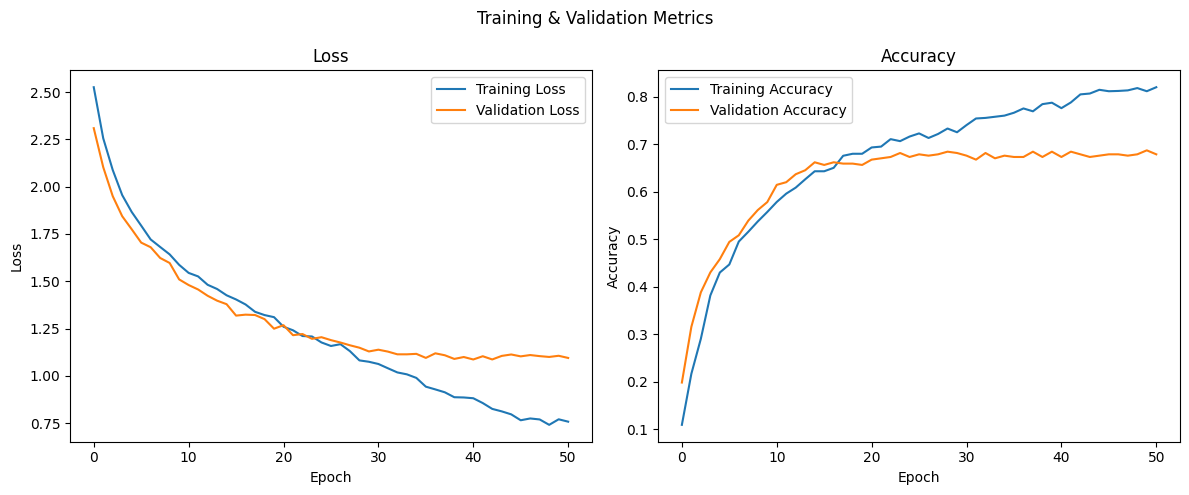

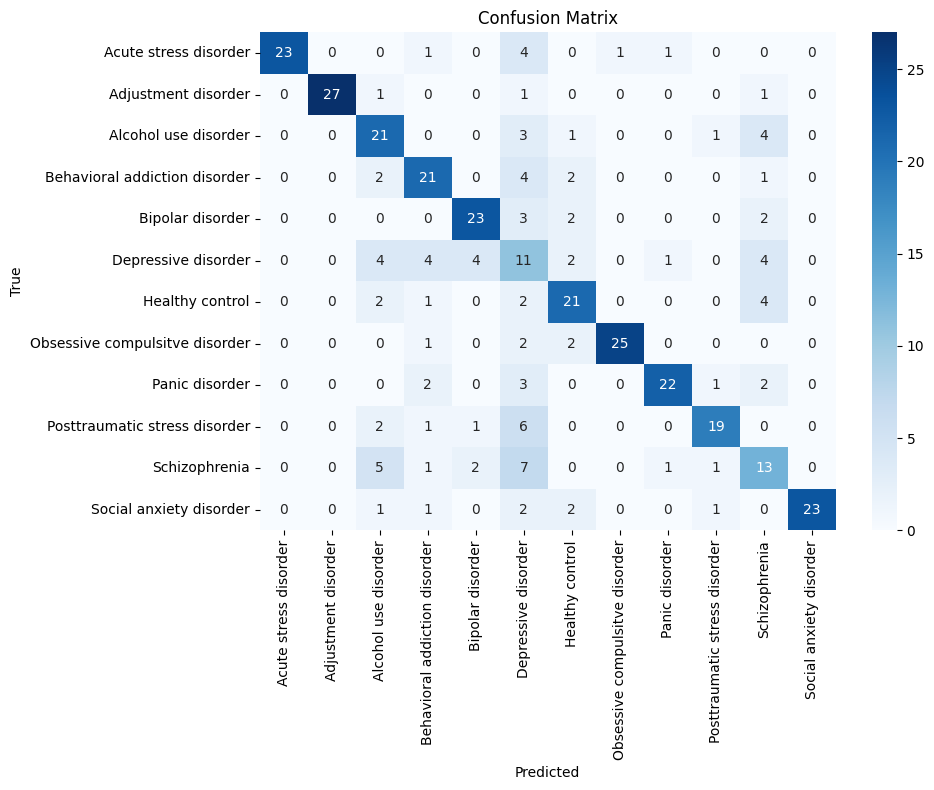

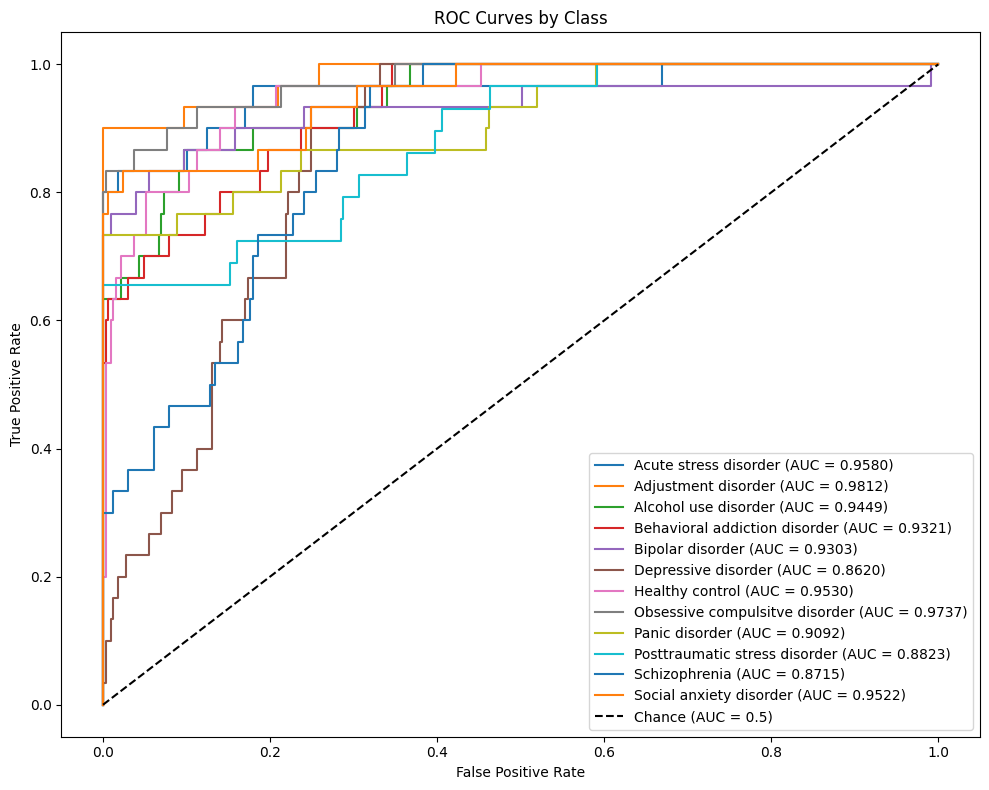

In [32]:
display(best_results['fig_curves'])
display(best_results['fig_conf_matrix'])
display(best_results['fig_roc'])

In [33]:
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

def cross_validate_model(
    X, y, 
    input_dim, output_dim, 
    neurons, dropout, learning_rate, batch_size, weight_decay,
    criterion, 
    class_names, num_classes, device,
    num_epochs=500
):
    accuracies = []
    aucs = []
    sensitivities = []
    specificities = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        print(f"\n- Fold {fold + 1}/{num_folds}")
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        X_train_scaled = SCALER.fit_transform(X_train)
        X_test_scaled = SCALER.transform(X_test)
        
        train_dataset = EEGDataset(X_train_scaled, y_train)
        test_dataset = EEGDataset(X_test_scaled, y_test)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        model = EEGANNClassifier(
            input_dim=input_dim,
            output_dim=output_dim,
            neurons=neurons,
            dropout=dropout
        ).to(device)
        
        optimizer = optim.Adam(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.1,
            patience=3,
            min_lr=1e-6,
            verbose=True
        )
        
        train_model_with_cv_folds(
            model=model,
            train_loader=train_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=num_epochs
        )
        
        model.eval()

        all_probs, all_labels = [], []
        correct, total = 0, 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                probs = F.softmax(outputs, dim=1)
                _, predicted = torch.max(probs, 1)

                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        all_probs = np.array(all_probs)
        all_labels = np.array(all_labels)
        pred_classes = np.argmax(all_probs, axis=1)
        accuracy = 100 * correct / total

        report, fold_sensitivities, fold_specificities = print_accuracy_report(
            accuracy, all_labels, pred_classes, class_names
        )

        auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro', labels=np.arange(num_classes))
        
        accuracies.append(accuracy)
        aucs.append(auc)
        sensitivities.append(fold_sensitivities)
        specificities.append(fold_specificities)

    # Calculate mean and std for all metrics across folds
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    
    mean_sens = {cls: np.mean([s[cls] for s in sensitivities]) for cls in class_names}
    std_sens = {cls: np.std([s[cls] for s in sensitivities]) for cls in class_names}
    
    mean_spec = {cls: np.mean([s[cls] for s in specificities]) for cls in class_names}
    std_spec = {cls: np.std([s[cls] for s in specificities]) for cls in class_names}
    
    return {
        'mean_accuracy': mean_accuracy,
        'std_accuracy': std_accuracy,
        'mean_auc': mean_auc,
        'std_auc': std_auc,
        'mean_sens': mean_sens,
        'std_sens': std_sens,
        'mean_spec': mean_spec,
        'std_spec': std_spec
    }

In [34]:
cv_results = cross_validate_model(
    X=X_concatenated, 
    y=y_encoded,
    input_dim=X_concatenated.shape[1],
    output_dim=len(np.unique(y_encoded)),
    neurons=best_params['neurons'],
    dropout=best_params['dropout'],
    learning_rate=best_params['learning_rate'],
    batch_size=best_params['batch_size'],
    weight_decay=best_params['weight_decay'],
    criterion=CRITERION,
    class_names=CLASS_NAMES,
    num_classes=len(np.unique(y_encoded)),
    device=device,
    num_epochs=NUM_EPOCHS
)


- Fold 1/5
Epoch [1/500] | Train Loss: 2.5308 | Train Acc: 0.1224
Epoch [2/500] | Train Loss: 2.2354 | Train Acc: 0.2173
Epoch [3/500] | Train Loss: 2.0675 | Train Acc: 0.3233
Epoch [4/500] | Train Loss: 1.9560 | Train Acc: 0.4177
Epoch [5/500] | Train Loss: 1.8454 | Train Acc: 0.4931
Epoch [6/500] | Train Loss: 1.7599 | Train Acc: 0.5485
Epoch [7/500] | Train Loss: 1.7030 | Train Acc: 0.5696
Epoch [8/500] | Train Loss: 1.6538 | Train Acc: 0.5944
Epoch [9/500] | Train Loss: 1.5913 | Train Acc: 0.6108
Epoch [10/500] | Train Loss: 1.5506 | Train Acc: 0.6150
Epoch [11/500] | Train Loss: 1.5309 | Train Acc: 0.6213
Epoch [12/500] | Train Loss: 1.4839 | Train Acc: 0.6445
Epoch [13/500] | Train Loss: 1.4334 | Train Acc: 0.6414
Epoch [14/500] | Train Loss: 1.4192 | Train Acc: 0.6503
Epoch [15/500] | Train Loss: 1.3967 | Train Acc: 0.6503
Epoch [16/500] | Train Loss: 1.3604 | Train Acc: 0.6661
Epoch [17/500] | Train Loss: 1.3449 | Train Acc: 0.6698
Epoch [18/500] | Train Loss: 1.3073 | Train A

## | 6. Results

In [37]:
# dataframe 
cv_df = pd.DataFrame({
    'Metric': ['Mean Accuracy', 'Std Accuracy', 'Mean AUC', 'Std AUC'] + 
              [f'Mean Sensitivity ({cls})' for cls in CLASS_NAMES] + 
              [f'Std Sensitivity ({cls})' for cls in CLASS_NAMES] + 
              [f'Mean Specificity ({cls})' for cls in CLASS_NAMES] + 
              [f'Std Specificity ({cls})' for cls in CLASS_NAMES],
    'Value': [
        cv_results['mean_accuracy'], cv_results['std_accuracy'],
        cv_results['mean_auc'], cv_results['std_auc']
    ] + 
    [cv_results['mean_sens'][cls] for cls in CLASS_NAMES] + 
    [cv_results['std_sens'][cls] for cls in CLASS_NAMES] + 
    [cv_results['mean_spec'][cls] for cls in CLASS_NAMES] + 
    [cv_results['std_spec'][cls] for cls in CLASS_NAMES]
})

cv_df

,Metric,Value
0,Mean Accuracy,66.876310
1,Std Accuracy,2.093620
2,Mean AUC,0.913216
3,Std AUC,0.008666
4,Mean Sensitivity (Acute stress disorder),0.804231
5,Mean Sensitivity (Adjustment disorder),0.808974
6,Mean Sensitivity (Alcohol use disorder),0.607949
7,Mean Sensitivity (Behavioral addiction disorder),0.628462
8,Mean Sensitivity (Bipolar disorder),0.683205
9,Mean Sensitivity (Depressive disorder),0.346282


In [38]:
rows = []

rows.append({
    'Class': 'Overall',
    'Metric': 'Accuracy',
    'Mean': cv_results['mean_accuracy'],
    'Std': cv_results['std_accuracy']
})
rows.append({
    'Class': 'Overall',
    'Metric': 'AUC',
    'Mean': cv_results['mean_auc'],
    'Std': cv_results['std_auc']
})

for cls in CLASS_NAMES:
    rows.append({
        'Class': cls,
        'Metric': 'Sensitivity',
        'Mean': cv_results['mean_sens'][cls],
        'Std': cv_results['std_sens'][cls]
    })
    rows.append({
        'Class': cls,
        'Metric': 'Specificity',
        'Mean': cv_results['mean_spec'][cls],
        'Std': cv_results['std_spec'][cls]
    })

cv_df_organized = pd.DataFrame(rows)

cv_df_organized = cv_df_organized.sort_values(by=['Class', 'Metric']).reset_index(drop=True)

cv_df_organized.to_csv('cross_validation_results_multiclass_spec_ann.csv', index=False)

cv_df_organized

,Class,Metric,Mean,Std
0,Acute stress disorder,Sensitivity,0.804231,0.055074
1,Acute stress disorder,Specificity,0.992229,0.006567
2,Adjustment disorder,Sensitivity,0.808974,0.037745
3,Adjustment disorder,Specificity,0.994975,0.003029
4,Alcohol use disorder,Sensitivity,0.607949,0.056638
5,Alcohol use disorder,Specificity,0.958417,0.014157
6,Behavioral addiction disorder,Sensitivity,0.628462,0.060366
7,Behavioral addiction disorder,Specificity,0.969859,0.007804
8,Bipolar disorder,Sensitivity,0.683205,0.061551
9,Bipolar disorder,Specificity,0.983092,0.005541


## | 7. Conclusions, Problems, and Limitations

[need to update]